# Use Cases

**Including use cases requires at least neo4j-runway v0.8.1**

This notebook covers how to declare and focus on use cases during data discovery and data model generation phases. Identifying use cases helps narrow the focus of the LLM and results in a more meaningful data model. 

In [8]:
from neo4j_runway import Discovery, UserInput, GraphDataModeler, LLM
import pandas as pd

First we read in our data on countries.

## Import Data

In [2]:
data = pd.read_csv("data/csv/countries.csv")
data.head()

,id,name,iso3,iso2,numeric_code,phone_code,capital,currency,currency_name,currency_symbol,tld,native,region,subregion,timezones,latitude,longitude,emoji,emojiU
0,1,Afghanistan,AFG,AF,4,93,Kabul,AFN,Afghan afghani,؋,.af,افغانستان,Asia,Southern Asia,"[{zoneName:'Asia\/Kabul',gmtOffset:16200,gmtOf...",33.000000,65.0,🇦🇫,U+1F1E6 U+1F1EB
1,2,Aland Islands,ALA,AX,248,+358-18,Mariehamn,EUR,Euro,€,.ax,Åland,Europe,Northern Europe,"[{zoneName:'Europe\/Mariehamn',gmtOffset:7200,...",60.116667,19.9,🇦🇽,U+1F1E6 U+1F1FD
2,3,Albania,ALB,AL,8,355,Tirana,ALL,Albanian lek,Lek,.al,Shqipëria,Europe,Southern Europe,"[{zoneName:'Europe\/Tirane',gmtOffset:3600,gmt...",41.000000,20.0,🇦🇱,U+1F1E6 U+1F1F1
3,4,Algeria,DZA,DZ,12,213,Algiers,DZD,Algerian dinar,دج,.dz,الجزائر,Africa,Northern Africa,"[{zoneName:'Africa\/Algiers',gmtOffset:3600,gm...",28.000000,3.0,🇩🇿,U+1F1E9 U+1F1FF
4,5,American Samoa,ASM,AS,16,+1-684,Pago Pago,USD,US Dollar,$,.as,American Samoa,Oceania,Polynesia,"[{zoneName:'Pacific\/Pago_Pago',gmtOffset:-396...",-14.333333,-170.0,🇦🇸,U+1F1E6 U+1F1F8


## Define User Inputs

Now we can fill out our UserInput object. This will contain all the important data we would like to communicate to the LLM during discovery and data model generation.

Here we can define our use cases. In this instance we'd like the data model to be able to solve three basic questions:
- Which region contains the most subregions?
- Which currencies are most popular?
- Which countries share timezones?

In [3]:
user_input = UserInput(
    general_description='This is data on different countries.',
    column_descriptions={
        'id': 'unique id for a country.',
        'name': 'the country name.',
        'phone_code': 'country area code.',
        'capital': 'the capital of the country.',
        'currency_name': "name of the country's currency.",
        'region': 'primary region of the country.',
        'subregion': 'subregion location of the country.',
        'timezones': 'timezones contained within the country borders.',
        'latitude': 'the latitude coordinate of the country center.',
        'longitude': 'the longitude coordinate of the country center.'
    },
    use_cases=[
        "Which region contains the most subregions?", 
        "What currencies are most popular?", 
        "Which countries share timezones?"
    ]
)

## Discover Insights

Now we can run initial discovery over our data, while keeping our use cases front of mind.

In [4]:
disc = Discovery(data=data, user_input=user_input, llm=LLM(model="gpt-4o-2024-05-13"), pandas_only=False)
disc.run(show_result=True, notebook=True)

### Preliminary Analysis of Country Data

#### Overall Details

1. **Data Completeness**:
   - The dataset contains 250 entries with 10 features.
   - Most features are complete, but there are some missing values:
     - `capital`: 5 missing values
     - `region`: 2 missing values
     - `subregion`: 3 missing values

2. **Data Types**:
   - The dataset includes a mix of data types:
     - Numerical: `id`, `latitude`, `longitude`
     - Categorical: `name`, `phone_code`, `capital`, `currency_name`, `region`, `subregion`, `timezones`

3. **Unique Values**:
   - `name`: 250 unique values (each country is unique)
   - `phone_code`: 235 unique values (some countries share phone codes)
   - `capital`: 244 unique values (one capital is shared by two countries)
   - `currency_name`: 161 unique values (some currencies are shared by multiple countries)
   - `region`: 6 unique values
   - `subregion`: 22 unique values
   - `timezones`: 245 unique values (some timezones are shared by multiple countries)

#### Important Features

1. **Region and Subregion**:
   - `region` and `subregion` are crucial for understanding geographical and political groupings.
   - `region` has 6 unique values, with Africa being the most frequent (60 occurrences).
   - `subregion` has 22 unique values, with the Caribbean being the most frequent (28 occurrences).

2. **Currency**:
   - `currency_name` is important for economic analysis.
   - The most common currency is the Euro, used by 35 countries.

3. **Timezones**:
   - `timezones` can help identify countries that share the same time zones.
   - There are 245 unique timezones, with the most common timezone being shared by 3 countries.

#### Use Case Analysis

1. **Which region contains the most subregions?**
   - To answer this, we need to count the number of unique subregions within each region.
   - Preliminary observation suggests that Africa is the most frequent region, but we need to check the diversity of subregions within each region.

2. **What currencies are most popular?**
   - The Euro is the most popular currency, used by 35 countries.
   - Other popular currencies can be identified by counting the frequency of each `currency_name`.

3. **Which countries share timezones?**
   - Countries sharing the same timezones can be identified by grouping the data by `timezones` and listing the countries within each group.
   - The most common timezone is shared by 3 countries.

### Summary

- **Important Features**: `region`, `subregion`, `currency_name`, `timezones`
- **Data Completeness**: Mostly complete with minor missing values in `capital`, `region`, and `subregion`.
- **Unique Values**: High uniqueness in `name`, `phone_code`, `capital`, `currency_name`, and `timezones`.

This preliminary analysis provides a foundation for further exploration and modeling, particularly focusing on regions, subregions, currencies, and timezones to address the specified use cases.

## Data Modeling

We now construct our data modeler and pass our discovery insights as context for model generation.

In [5]:
gdm = GraphDataModeler(llm=LLM(model="gpt-4o-2024-05-13"), discovery=disc)

In [6]:
gdm.create_initial_model()

validation message: 
 
The following data model is invalid and must be fixed.
Properties must be from the provided Column Options. 
Data Model:
{'nodes': [{'label': 'Country', 'properties': [{'name': 'id', 'type': 'int', 'csv_mapping': 'id', 'csv_mapping_other': None, 'is_unique': True, 'part_of_key': True}, {'name': 'name', 'type': 'str', 'csv_mapping': 'name', 'csv_mapping_other': None, 'is_unique': False, 'part_of_key': False}, {'name': 'phoneCode', 'type': 'str', 'csv_mapping': 'phone_code', 'csv_mapping_other': None, 'is_unique': False, 'part_of_key': False}, {'name': 'capital', 'type': 'str', 'csv_mapping': 'capital', 'csv_mapping_other': None, 'is_unique': False, 'part_of_key': False}, {'name': 'latitude', 'type': 'float', 'csv_mapping': 'latitude', 'csv_mapping_other': None, 'is_unique': False, 'part_of_key': False}, {'name': 'longitude', 'type': 'float', 'csv_mapping': 'longitude', 'csv_mapping_other': None, 'is_unique': False, 'part_of_key': False}], 'csv_name': ''}, {'label'

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', csv_mapping_other=None, is_unique=True, part_of_key=False), Property(name='name', type='str', csv_mapping='name', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='str', csv_mapping='phone_code', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', csv_mapping='capital', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', csv_mapping='latitude', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', csv_mapping='longitude', csv_mapping_other=None, is_unique=False, part_of_key=False)], csv_name=''), Node(label='Region', properties=[Property(name='name', type='str', csv_mapping='region', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='Subregion', properties=[Property(n

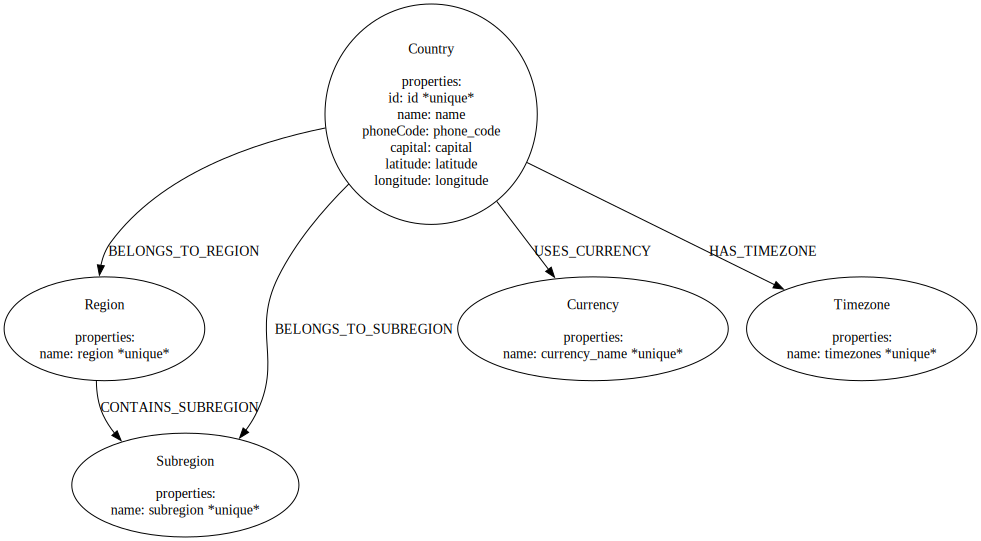

In [7]:
gdm.current_model.visualize()

The initial data model seems to be able to provide answers to our questions.
- Which region contains the most subregions?  **&#8594;** We can match on Region nodes and count the their relationships with Subregion nodes

- Which currencies are most popular? **&#8594;** We can match on Currency nodes and count their relationships to Country nodes

- Which countries share timezones? **&#8594;** We can match on Country nodes and traverse through Timezone nodes, looking for different Country nodes